# Importações

In [171]:
import os
import cv2
import random
from tqdm import tqdm
import numpy as np

from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras import layers, Model, Input
from tensorflow import keras
import tensorflow as tf
from sklearn.metrics import f1_score, precision_score, recall_score


## Utils

In [172]:
def get_image_paths(data_dir):
    image_paths = []
    
    for subdir, _, files in os.walk(data_dir):
        for file in files:
            if file.lower().endswith(('.png', '.jpg', '.jpeg')):
                image_paths.append(os.path.join(subdir, file))
    
    return image_paths

# Diretório com subdiretórios contendo imagens
data_dir = 'post-processed'
image_paths = get_image_paths(data_dir)

In [173]:
def preprocess(file_path, target_size=(112, 112)):
    byte_img = tf.io.read_file(file_path)
    img = tf.io.decode_jpeg(byte_img)
    img = tf.image.resize(img, (112, 112))
    img = img / 255.0
    return img


In [174]:
def create_triplets(data_dir):
    anchor_paths = []
    positive_paths = []
    negative_paths = []
    
    people = os.listdir(data_dir)
    
    for person in people:
        person_dir = os.path.join(data_dir, person)
        images = os.listdir(person_dir)
        
        if len(images) < 2:
            # Se a pessoa tem menos de 2 imagens, não pode formar âncora e positiva
            continue
        
        for _ in range(len(images)):  # Podemos gerar vários triplets por pessoa
            # Seleciona aleatoriamente âncora e positiva (da mesma pessoa)
            anchor, positive = random.sample(images, 2)
            anchor_path = os.path.join(person_dir, anchor)
            positive_path = os.path.join(person_dir, positive)
            
            # Seleciona uma pessoa diferente para a imagem negativa
            negative_person = random.choice([p for p in people if p != person])
            negative_person_dir = os.path.join(data_dir, negative_person)
            negative_images = os.listdir(negative_person_dir)
            negative = random.choice(negative_images)
            negative_path = os.path.join(negative_person_dir, negative)
            
            # Adiciona os paths para os triplets
            anchor_paths.append(anchor_path)
            positive_paths.append(positive_path)
            negative_paths.append(negative_path)
    
    return anchor_paths, positive_paths, negative_paths

In [175]:
def generate_triplet_batches(data_dir, batch_size=32):
    while True:
        anchor_paths, positive_paths, negative_paths = create_triplets(data_dir)
        
        # Shuffle paths if needed
        indices = np.arange(len(anchor_paths))
        np.random.shuffle(indices)
        
        for start in range(0, len(anchor_paths), batch_size):
            end = min(start + batch_size, len(anchor_paths))
            batch_indices = indices[start:end]
            
            anchor_batch = [preprocess(path) for path in np.array(anchor_paths)[batch_indices]]
            positive_batch = [preprocess(path) for path in np.array(positive_paths)[batch_indices]]
            negative_batch = [preprocess(path) for path in np.array(negative_paths)[batch_indices]]
            
            yield (np.array(anchor_batch), np.array(positive_batch), np.array(negative_batch))

In [176]:
import matplotlib.pyplot as plt

def plot_triplets(anchor_images, positive_images, negative_images, n_samples=5):
    fig, axes = plt.subplots(n_samples, 3, figsize=(15, 5 * n_samples))
    
    for i in range(n_samples):
        # Exibe a imagem âncora
        axes[i, 0].imshow(anchor_images[i])
        axes[i, 0].set_title('Anchor')
        axes[i, 0].axis('off')
        
        # Exibe a imagem positiva
        axes[i, 1].imshow(positive_images[i])
        axes[i, 1].set_title('Positive')
        axes[i, 1].axis('off')
        
        # Exibe a imagem negativa
        axes[i, 2].imshow(negative_images[i])
        axes[i, 2].set_title('Negative')
        axes[i, 2].axis('off')
    
    plt.tight_layout()
    plt.show()


<class 'tuple'>
3
(5, 112, 112, 3) (5, 112, 112, 3) (5, 112, 112, 3)


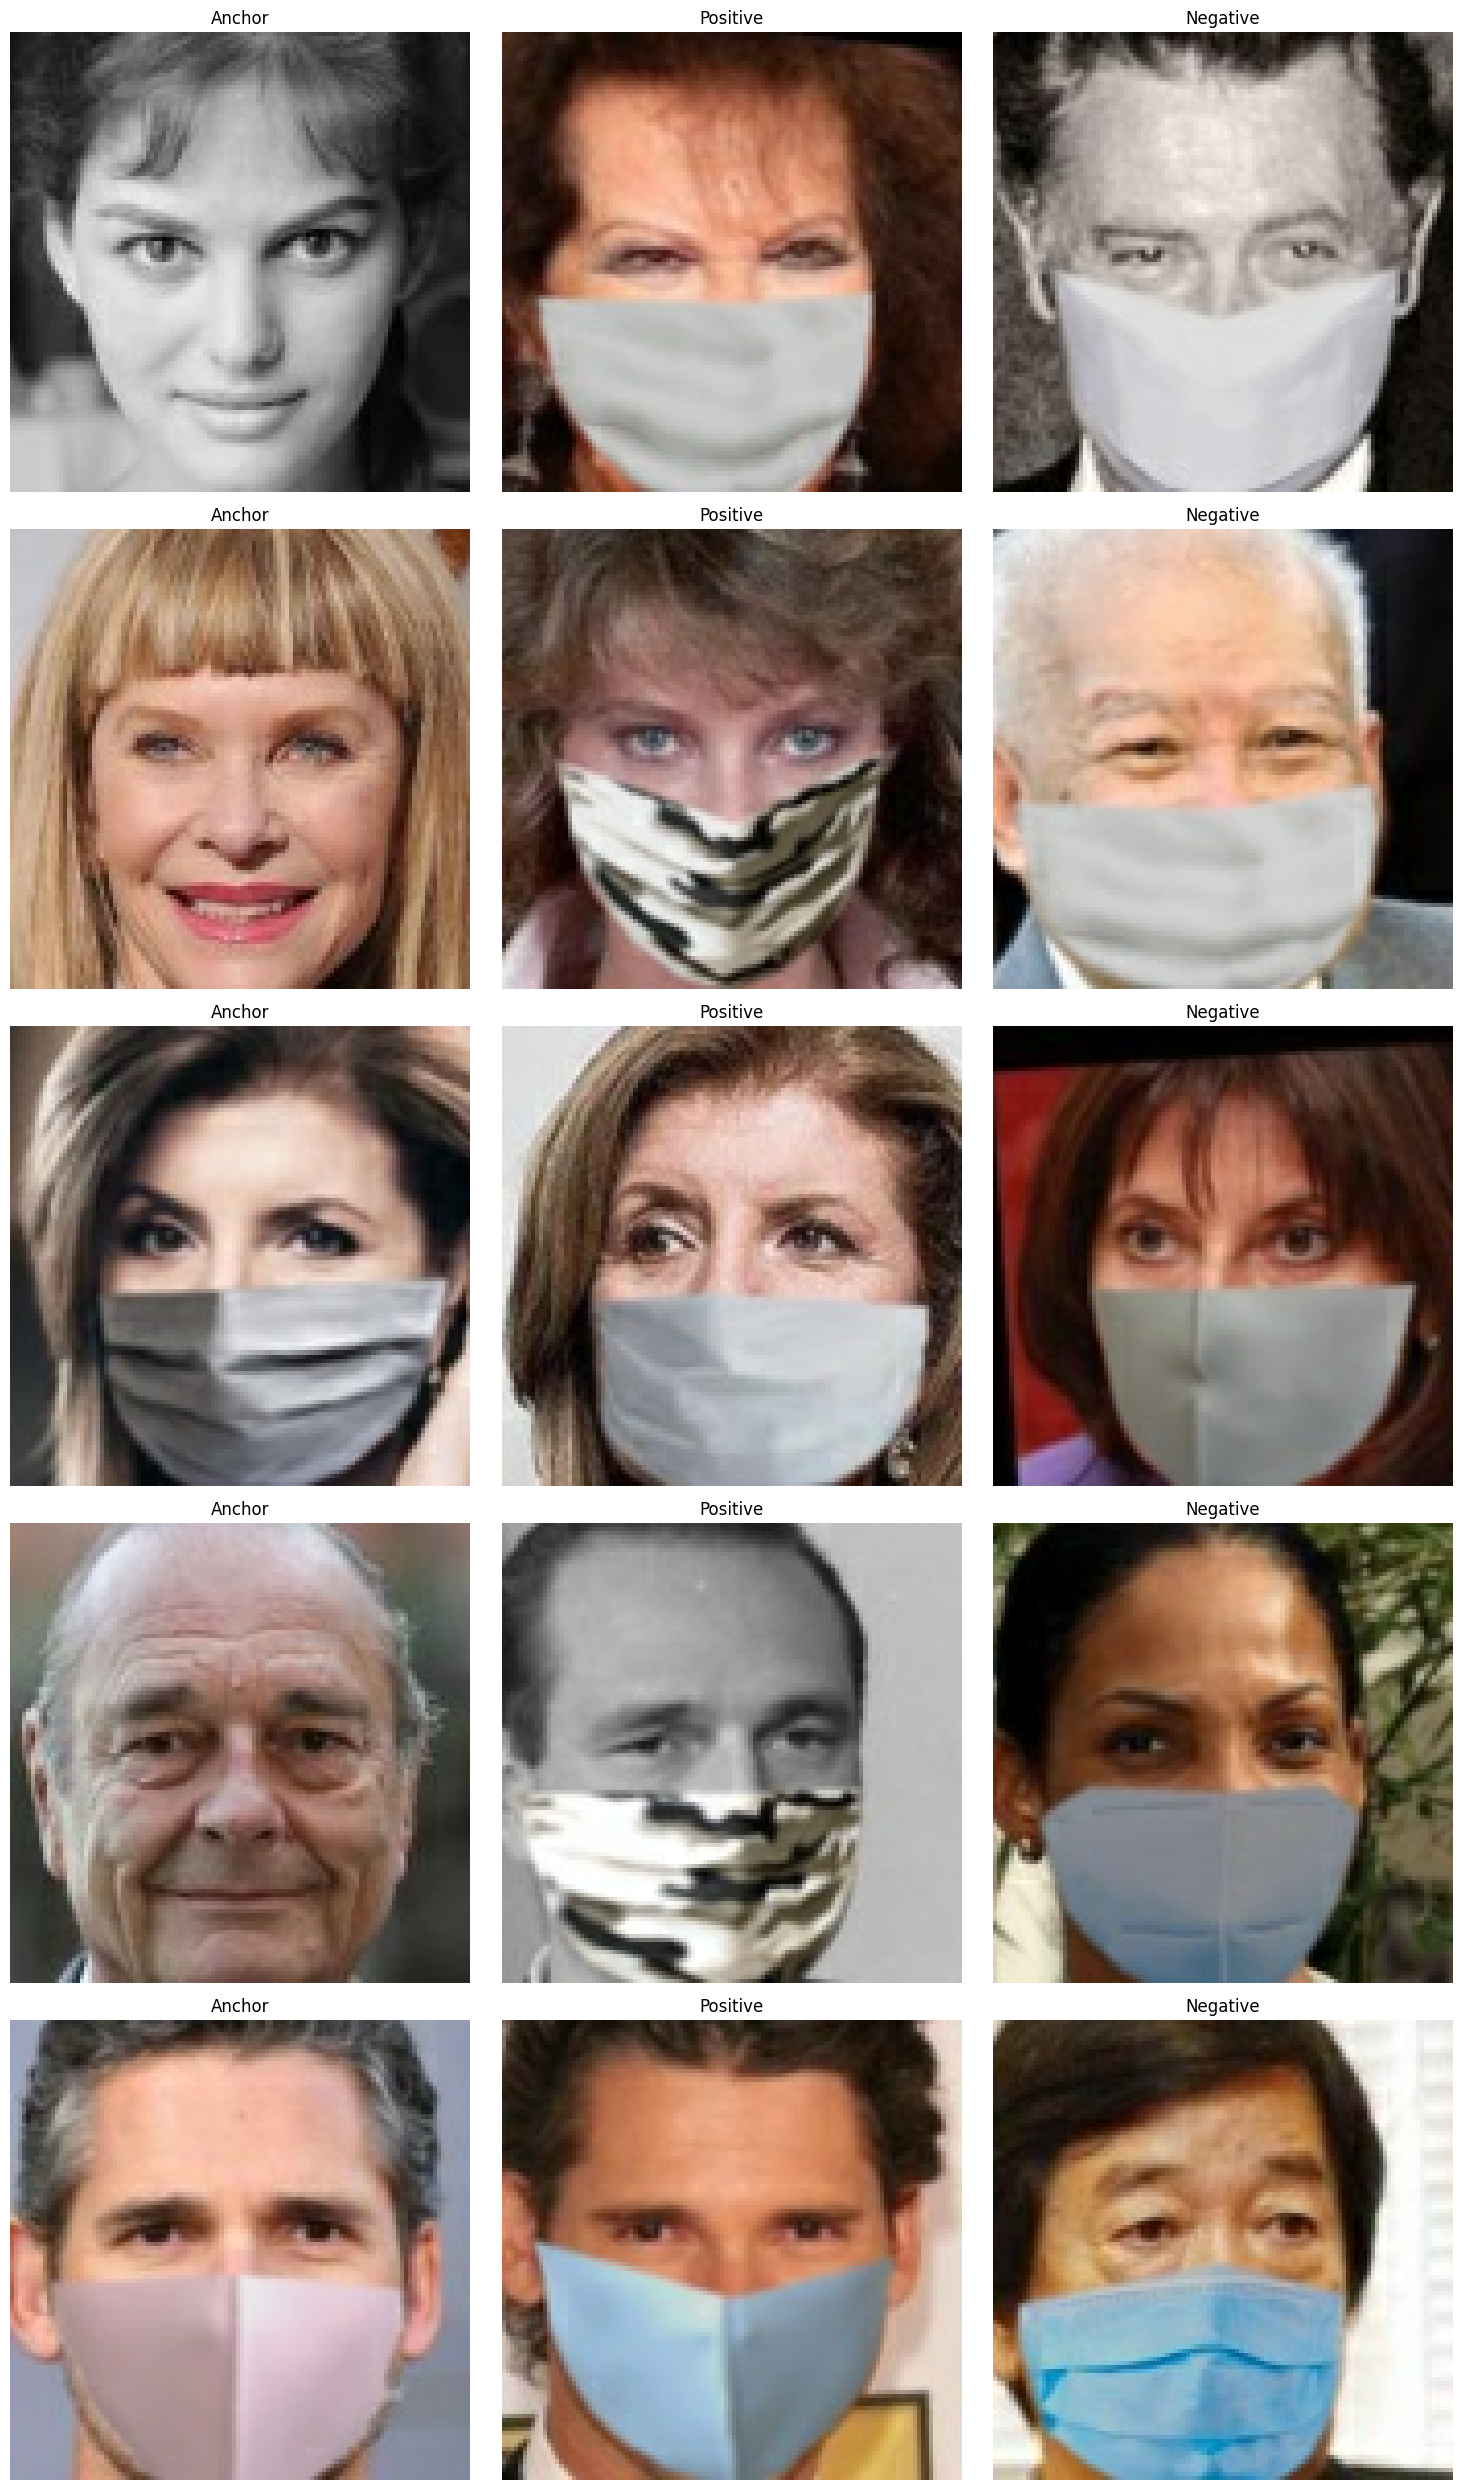

In [177]:
data_dir = 'post-processed'

triplet_gen = generate_triplet_batches(data_dir, batch_size=5)  # Ajuste o batch_size conforme necessário
batch = next(triplet_gen)  

print(type(batch))  # Deve ser uma tupla
print(len(batch))   # Deve ser 3

anchor_images, positive_images, negative_images = batch
print(anchor_images.shape, positive_images.shape, negative_images.shape)


plot_triplets(anchor_images, positive_images, negative_images)

## Inicializa o MobileNet

In [178]:
def get_embedding_model(input_shape=(112, 112, 3)):
    base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)
    base_model.trainable = False 

    inputs = layers.Input(shape=input_shape)
    
    embeddings = base_model(inputs)
    embeddings = layers.GlobalAveragePooling2D()(embeddings)  # Pooling para reduzir as dimensões
    
    # Adicionar camadas densas para o aprendizado da representação (embedding)
    x = layers.Dense(units=1024, activation="relu")(embeddings)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(units=512, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    x = layers.BatchNormalization()(x)
    
    x = layers.Dense(units=256, activation="relu")(x)
    x = layers.Dropout(0.2)(x)
    
    outputs = layers.Dense(units=128)(x)
    
    embedding_model = Model(inputs=inputs, outputs=outputs, name="embedding_model")
    return embedding_model

In [179]:
embedding_model = get_embedding_model()
embedding_model.summary()

C:\Users\amissadai.pinheiro\AppData\Local\Temp\ipykernel_26732\964978814.py:2: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base_model = MobileNetV2(weights='imagenet', include_top=False, input_shape=input_shape)


Model: "embedding_model"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_7 (InputLayer)      │ (None, 112, 112, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ mobilenetv2_1.00_224            │ (None, 4, 4, 1280)     │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d_3      │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_12 (Dense)                │ (None, 1024)           │     1,311,744 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_9 (Dropout)             │ (None, 1024)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_6           │ (None, 1024)           │         4,096 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 512)            │       524,800 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_10 (Dropout)            │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_7           │ (None, 512)            │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_14 (Dense)                │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_11 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 128)            │        32,896 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,264,896 (16.27 MB)

 Trainable params: 2,003,840 (7.64 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

## Triplet Loss Function

In [180]:
def triplet_loss(y_pred, margin=0.2):
    anchor, positive, negative = y_pred[0], y_pred[1], y_pred[2]
    pos_dist = tf.reduce_sum(tf.square(anchor - positive), axis=-1)
    neg_dist = tf.reduce_sum(tf.square(anchor - negative), axis=-1)
    basic_loss = pos_dist - neg_dist + margin
    loss = tf.maximum(basic_loss, 0.0)
    return tf.reduce_mean(loss)

##  Building Network

In [181]:
def get_network(embedding_model, input_shape=(112, 112, 3)):
    anchor_input = Input(name="anchor", shape=input_shape)
    positive_input = Input(name="positive", shape=input_shape)
    negative_input = Input(name="negative", shape=input_shape)
    
    anchor_embedding = embedding_model(anchor_input)
    positive_embedding = embedding_model(positive_input)
    negative_embedding = embedding_model(negative_input)
    
    siamese_network = Model(
        inputs=[anchor_input, positive_input, negative_input],
        outputs=[anchor_embedding, positive_embedding, negative_embedding]
    )
    
    return siamese_network

In [182]:
siamese_network = get_network(embedding_model)
siamese_network.summary()

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ anchor (InputLayer) │ (None, 112, 112,  │          0 │ -                 │
│                     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ positive            │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ negative            │ (None, 112, 112,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding_model     │ (None, 128)       │  4,264,896 │ anchor[0][0],     │
│ (Functional)        │                   │            │ positive[0][0],   │
│                     │                   │            │ negative[0][0]    │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 4,264,896 (16.27 MB)

 Trainable params: 2,003,840 (7.64 MB)

 Non-trainable params: 2,261,056 (8.63 MB)

## Training

In [183]:
opt = tf.keras.optimizers.Adam()
checkpoint_dir = './training_triplet_checkpoints'
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')
checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_network)

def siamese_train_step(siamese_network, optimizer, data, margin=0.2):
    
    anchor, positive, negative = data

    with tf.GradientTape() as tape:
        anchor_embedding, positive_embedding, negative_embedding = siamese_network((anchor, positive, negative))
        loss = triplet_loss([anchor_embedding, positive_embedding, negative_embedding], margin=margin)
        
    gradients = tape.gradient(loss, siamese_network.trainable_variables)
    optimizer.apply_gradients(zip(gradients, siamese_network.trainable_variables))

    return loss

Epoch 1/100
Step 0: Loss = 0.5487497448921204
Step 10: Loss = 0.2939024269580841
Step 20: Loss = 0.3531948924064636
Step 30: Loss = 0.1389370709657669
Step 40: Loss = 0.3770647644996643
Step 50: Loss = 0.22832293808460236
Step 60: Loss = 0.2386646568775177
Step 70: Loss = 0.06639205664396286
Step 80: Loss = 0.28785440325737
Step 90: Loss = 0.23204505443572998
Epoch 1 - Average Loss = 0.26864058401435614
Checkpoint saved at epoch 1
Epoch 2/100
Step 0: Loss = 0.14888903498649597
Step 10: Loss = 0.06484530121088028
Step 20: Loss = 0.22915545105934143
Step 30: Loss = 0.11400987952947617
Step 40: Loss = 0.07833971828222275
Step 50: Loss = 0.14314115047454834
Step 60: Loss = 0.7208136320114136
Step 70: Loss = 0.1888386458158493
Step 80: Loss = 0.0786832794547081
Step 90: Loss = 0.28858447074890137
Epoch 2 - Average Loss = 0.20800622820854187
Checkpoint saved at epoch 2
Epoch 3/100
Step 0: Loss = 0.27012205123901367
Step 10: Loss = 0.21923013031482697
Step 20: Loss = 0.16786235570907593
Step 

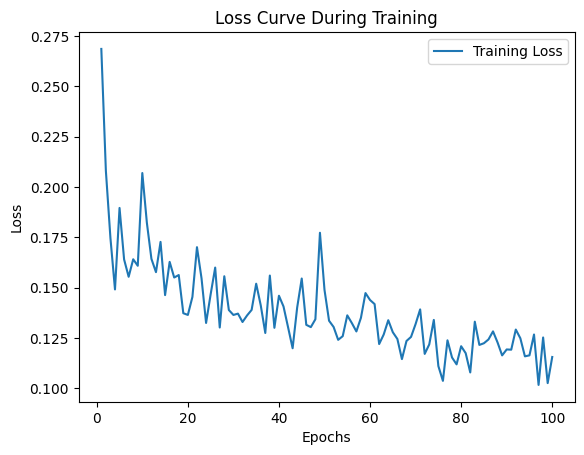

In [185]:
import matplotlib.pyplot as plt

def train_siamese_network(siamese_network, optimizer, triplet_gen, epochs, steps_per_epoch, checkpoint):
    loss_history = []  

    for epoch in range(epochs):
        epoch_loss = 0  
        print(f"Epoch {epoch+1}/{epochs}")
        
        for step in range(steps_per_epoch):
            data = next(triplet_gen)
            loss = siamese_train_step(siamese_network, optimizer, data)
            epoch_loss += loss.numpy()  
            
            if step % 10 == 0:
                print(f"Step {step}: Loss = {loss.numpy()}")
        
        # Calcular a perda média da época
        avg_epoch_loss = epoch_loss / steps_per_epoch
        loss_history.append(avg_epoch_loss)
        print(f"Epoch {epoch+1} - Average Loss = {avg_epoch_loss}")
        
        # Salvar o checkpoint ao final de cada época
        checkpoint.save(file_prefix=checkpoint_prefix)
        print(f"Checkpoint saved at epoch {epoch+1}")
    
    # Após o treinamento, plotar a curva de perda
    plt.plot(range(1, epochs+1), loss_history, label='Training Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Loss Curve During Training')
    plt.legend()
    plt.show()

# Número de épocas e passos por época
epochs = 100
steps_per_epoch = 100  # Ajuste conforme necessário

# Treinando o modelo
train_siamese_network(siamese_network, opt, triplet_gen, epochs, steps_per_epoch, checkpoint)


## Gerar Banco de Embedding

In [186]:
def generate_embeddings(siamese_network, image_paths, batch_size=32):
    embeddings = []
    for i in range(0, len(image_paths), batch_size):
        batch_paths = image_paths[i:i + batch_size]
        batch_images = [preprocess(p) for p in batch_paths]
        batch_images = tf.stack(batch_images)
        
        # Gerar embeddings para o lote
        batch_embeddings = siamese_network.predict([batch_images, batch_images, batch_images])
        embeddings.append(batch_embeddings)
    
    return np.concatenate(embeddings, axis=0)

# Gerar embeddings
embeddings = generate_embeddings(siamese_network, image_paths)

# Salvar embeddings em um arquivo NumPy
np.save('embeddings.npy', embeddings)

1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 329ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 272ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 278ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 273ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 276ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 279ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 295ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 305ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 316ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 308ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 286ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 283ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 282ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 294ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 303ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 280ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 

In [ ]:
embeddings.shape

(1125, 32, 128)

In [ ]:
def add_embedding(siamese_network, new_image_path, existing_embeddings_path='embeddings.npy'):    
    # Carregar o banco de embeddings existente
    existing_embeddings = np.load(existing_embeddings_path)
    print('shape do banco.: ', existing_embeddings.shape)
    # Preprocessar a nova imagem
    new_image = preprocess(new_image_path)
    new_image = tf.expand_dims(new_image, axis=0)  # Adicionar dimensão do lote
    print('shape da nova Imagem.: ', new_image.shape)
    
    # Gerar o embedding para a nova imagem
    new_embedding = siamese_network.predict([new_image, new_image, new_image])
    print('tipo.: ',type(new_embedding))
    new_embedding = np.array(new_embedding)
    new_embedding = new_embedding[0]
    new_embedding = np.expand_dims(new_embedding, axis=1)  # Forma (1, 1, 128)
    new_embedding = np.repeat(new_embedding, 32, axis=1)  # Forma (1, 32, 128)

    print('Forma do novo embedding antes do ajuste.: ', new_embedding.shape)
    
    # Adicionar o novo embedding ao banco existente
    updated_embeddings = np.concatenate([existing_embeddings, new_embedding], axis=0)
    print('cheguei aqui', updated_embeddings.shape)
    # Salvar o banco de embeddings atualizado
    np.save(existing_embeddings_path, updated_embeddings)
    print("Novo embedding adicionado e banco de dados atualizado.")


# Exemplo de uso
new_image_path = 'marcelinho_no_db.jpg'
add_embedding(siamese_network, new_image_path)



shape do banco.:  (1125, 32, 128)
shape da nova Imagem.:  (1, 112, 112, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step
tipo.:  <class 'list'>
Forma do novo embedding antes do ajuste.:  (1, 32, 128)
cheguei aqui (1126, 32, 128)
Novo embedding adicionado e banco de dados atualizado.


In [ ]:
embeddings_atual = np.load('embeddings.npy')

In [ ]:
embeddings_atual.shape

(1126, 32, 128)

## Inference

Shape da iamgem.:  (112, 112, 3)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step
Dimensão do embedding gerado após squeeze: (1, 32, 128)
Dimensão dos embeddings salvos: (1126, 32, 128)
Dimensão do embedding ajustado: (1, 4096)
Dimensão dos embeddings salvos ajustados: (1126, 4096)
O índice do embedding mais semelhante é: 966
A similaridade é: 0.802838921546936


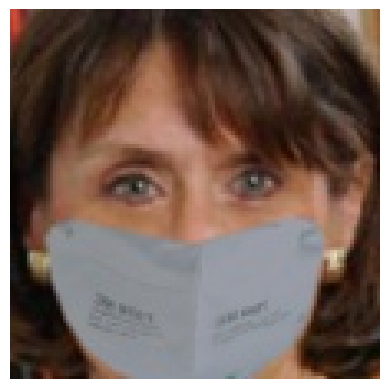

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity


def get_embedding(model, image_path):
    img = preprocess(image_path)
    print('Shape da iamgem.: ',img.shape)
    img = tf.expand_dims(img, axis=0)  # Adicionar a dimensão do lote
    embedding = model.predict([img, img, img])
    embedding = np.array(embedding)
    embedding = embedding[0]
    embedding = np.expand_dims(embedding, axis=1)  # Forma (1, 1, 128)
    embedding = np.repeat(embedding, 32, axis=1)  # Forma (1, 32, 128)
    print(f"Dimensão do embedding gerado após squeeze: {embedding.shape}")
    
    return embedding

masked_image_path = 'marcelinho_na_inferencia.jpg'
masked_embedding = get_embedding(siamese_network, masked_image_path)

saved_embeddings = np.load('embeddings.npy')

# Verificar a dimensão dos embeddings salvos
print(f"Dimensão dos embeddings salvos: {saved_embeddings.shape}")


# Ajustar o formato do embedding gerado
masked_embedding = masked_embedding.reshape(1, -1)  # Forma (1, 32*128)
saved_embeddings = saved_embeddings.reshape(saved_embeddings.shape[0], -1)  # Forma (1125, 32*128)

# Verificar o formato do embedding após ajuste
print(f"Dimensão do embedding ajustado: {masked_embedding.shape}")
print(f"Dimensão dos embeddings salvos ajustados: {saved_embeddings.shape}")

similarities = cosine_similarity(masked_embedding, saved_embeddings)

# Encontrar o índice do embedding mais semelhante
most_similar_index = np.argmax(similarities)

print(f'O índice do embedding mais semelhante é: {most_similar_index}')
print(f'A similaridade é: {similarities[0, most_similar_index]}')

# Opcional: mostrar a imagem mais semelhante do banco de dados
import matplotlib.pyplot as plt
from PIL import Image

def display_image(image_path):
    img = Image.open(image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()

# Assumindo que image_paths contém os caminhos das imagens correspondentes aos embeddings
most_similar_image_path = image_paths[most_similar_index]
display_image(most_similar_image_path)
